# Feb 2nd, 2022 (Mouse ICA)

**Motivation**: Look at mouse ICA components.  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [86]:
# HIDE CODE


def coronal(partition, figsize=(13, 12), cmap='tab20c'):
    fig, axes = create_figure(5, 4, figsize)

    slices = range(28, partition.shape[1], 6)
    for i, ax in enumerate(axes.flat):
        try:
            x2plt = partition[:, slices[i], :].T[::-1]
        except IndexError:
            continue
       #  x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        ax.imshow(x2plt, cmap=cmap, vmin=1, vmax=np.nanmax(partition))
    remove_ticks(axes)
    plt.show()
    

def sagittal(partition, figsize=(13.5, 12), cmap='tab20c'):
    fig, axes = create_figure(5, 4, figsize)

    slices = range(12, partition.shape[0], 5)
    for i, ax in enumerate(axes.flat):
        try:
            x2plt = partition[slices[i]].T[::-1]
        except IndexError:
            continue
        # x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        ax.imshow(x2plt, cmap=cmap, vmin=1, vmax=np.nanmax(partition))
    remove_ticks(axes)
    plt.show()
    

def axial(partition, figsize=(13.5, 12), cmap='tab20c'):
    fig, axes = create_figure(5, 4, figsize)

    slices = range(12, partition.shape[2], 4)
    for i, ax in enumerate(axes.flat):
        try:
            x2plt = partition[..., slices[i]] # .T[::-1]
        except IndexError:
            continue
        # x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        ax.imshow(x2plt, cmap=cmap, vmin=1, vmax=np.nanmax(partition))
    remove_ticks(axes)
    plt.show()

## Allen

In [3]:
from register.atlas import Allen
al = Allen()

In [4]:
from allensdk.core.reference_space_cache import ReferenceSpaceCache

reference_space_key = 'annotation/ccf_2017'
resolution = 10
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest='manifest.json')
rsp = rspc.get_reference_space()

In [5]:
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1)
acro_map = tree.value_map(lambda x: x['id'], lambda y: y['acronym'])
acro_map[315]

'Isocortex'

## Grandjean

In [66]:
_dir = '/home/hadi/Documents/MouseICA'
file = 'DSURQE_100micron_DRICA.nii.gz'
file = pjoin(_dir, file)
img = ants.image_read(file)
x = img.numpy()
x[x == 0] = np.nan

img

ANTsImage
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (126, 191, 96, 18)
         Spacing    : (0.1, 0.1, 0.1, 1.0)
         Origin     : (6.27, 8.19, -4.2, 0.0)
         Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

### Argmax

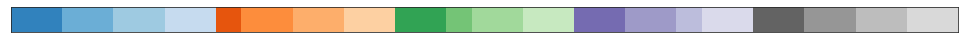

In [67]:
cmap = sns.color_palette('tab20c', as_cmap=True) # get_rand_cmap(200)
display_cmap(cmap)

In [68]:
mask = np.abs(x).mean(-1) > 0
partition = 1 + np.argmax(x.reshape(-1, x.shape[-1]), -1)
partition = partition.reshape(x.shape[:3]).astype(float)
partition[~mask] = np.nan

#### Coronal

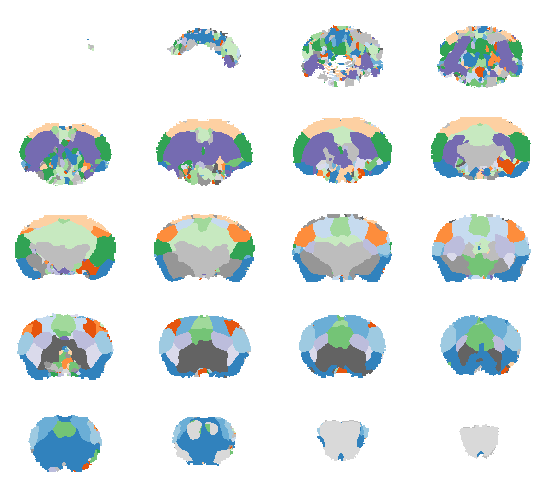

In [90]:
coronal(partition, (8, 7))

#### Sagittal

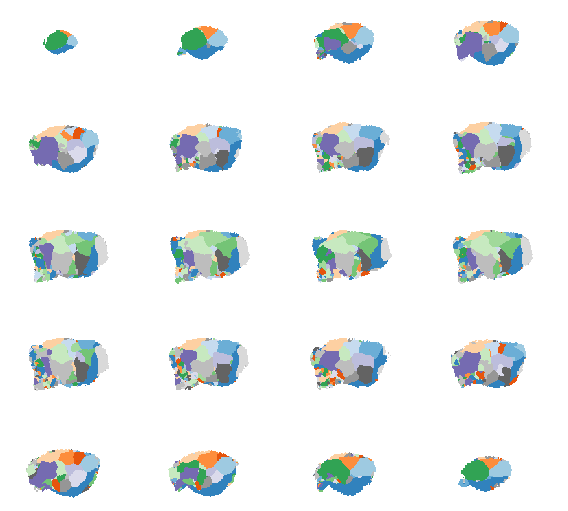

In [91]:
sagittal(partition, (8, 8))

#### Axial

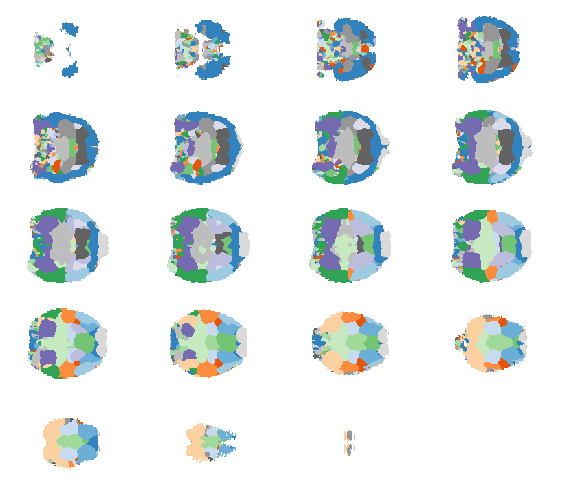

In [92]:
axial(partition, (8, 7))

### Combine

In [93]:
combined = {
    'thal': [16],
    'olf': [0, 17],
    'sensory': [1, 6, 7], 
    'basal': [12, 13, 14],
    'ss': [2, 3, 4, 5],
    'limbic': [8, 9, 10, 11, 15],
}

In [94]:
partition_comb = dc(partition)
for i, clist in enumerate(combined.values()):
    for j in clist:
        partition_comb[partition == j + 1] = i + 1
np.unique(partition_comb[np.isfinite(partition_comb)])

array([1., 2., 3., 4., 5., 6.])

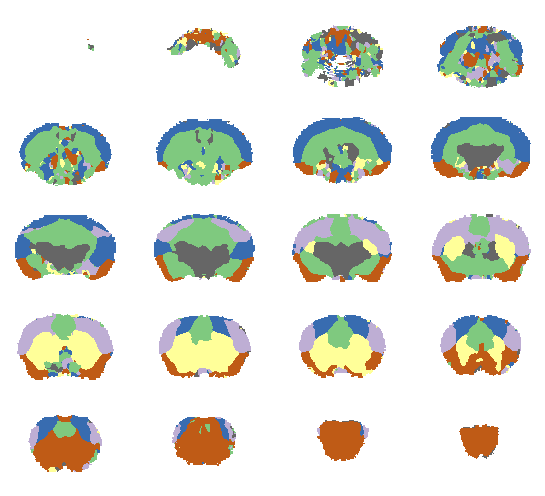

In [95]:
coronal(partition_comb, (8, 7), 'Accent_r')

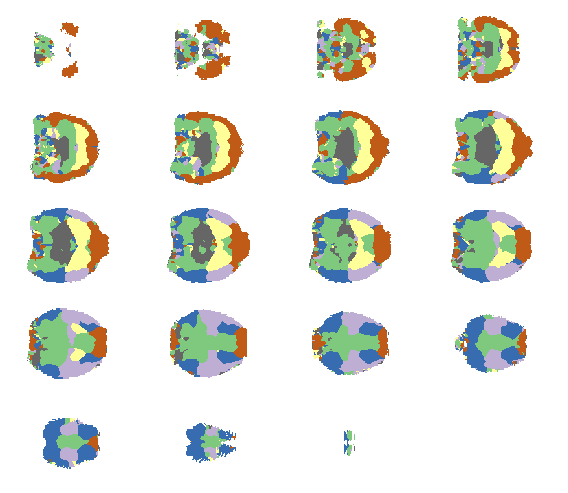

In [97]:
axial(partition_comb, (8, 7), 'Accent_r')

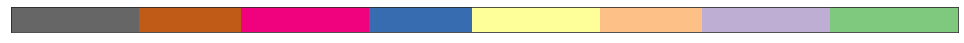

In [101]:
display_cmap(sns.color_palette('Accent_r', n_colors=6, as_cmap=True))

In [ ]:
dkm = []

### Components

In [12]:
def comp_plt(component, slices, title, other_slices=None):
    fig, axes = create_figure(2, 3, (12, 5.2), width_ratios=[1., 1., 1])

    for i in range(3):
        # ARA
        x2plt = rsp.get_slice_image(i, slices[i])
        if i == 0:
            j = 1
        else:
            j = 0 if i == 2 else 2
            x2plt = np.transpose(x2plt, (1, 0, 2))[:, ::-1, :]
        axes[0, j].imshow(x2plt, interpolation='none')

        # ICA
        x2plt = x[..., component]
        if other_slices is None:
            x2plt = bn.nanmean(x2plt, i)
        else:
            x2plt = np.take(x2plt, other_slices[i], i)
        
        if i != 2:
            x2plt = x2plt[:, ::-1].T
        axes[1, i].imshow(x2plt, cmap='icefire')
    fig.suptitle(title, fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.show()

#### Component 0

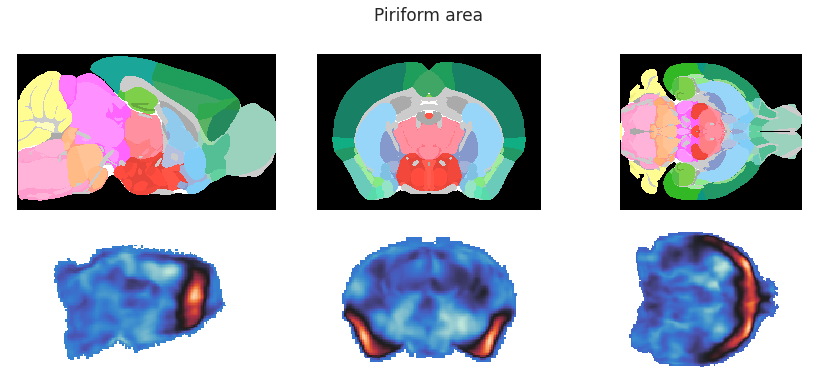

In [13]:
title = 'Piriform area'
comp_plt(0, [6000, 5000, 5000], title, [65, 90, 40])

#### Component 1

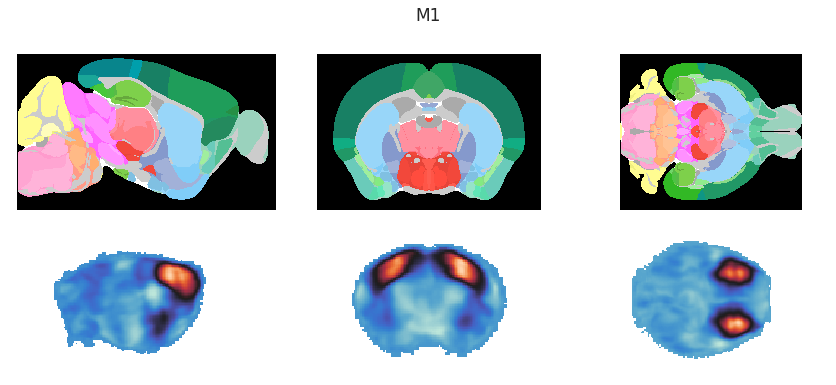

In [14]:
title = 'M1'
comp_plt(1, [5900, 5000, 4000], title, [35, 112, 67])

#### Component 2

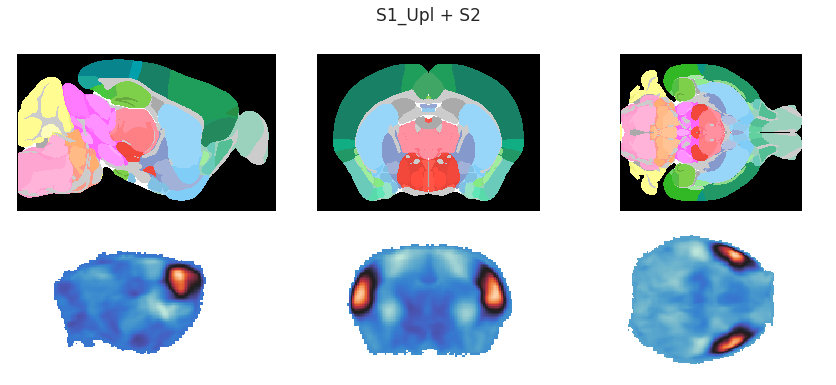

In [15]:
title = 'S1_Upl + S2'
comp_plt(2, [5900, 5000, 4000], title, [35, 105, 60])

#### Component 3

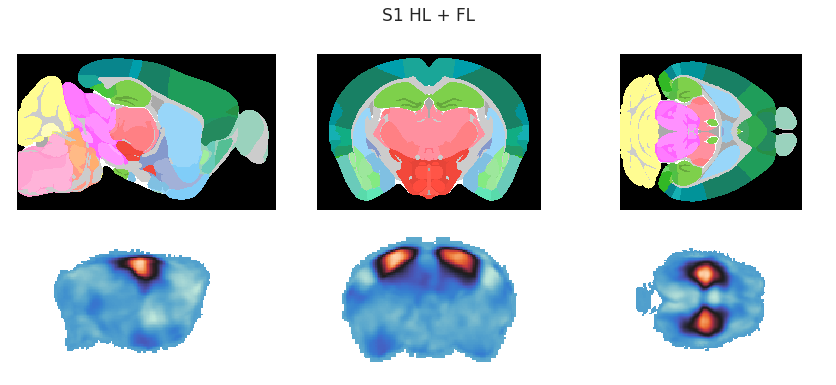

In [16]:
title = 'S1 HL + FL'
comp_plt(3, [7000, 3000, 4000], title, [38, 90, 73])

#### Component 4

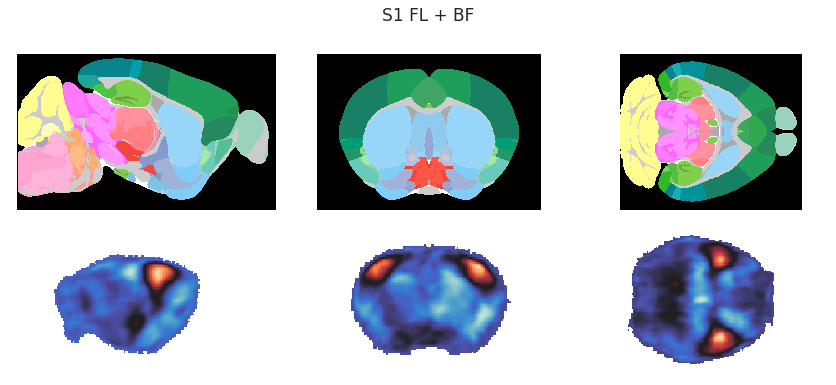

In [17]:
title = 'S1 FL + BF'
comp_plt(4, [5000, 3000, 4000], title, [30, 110, 60])

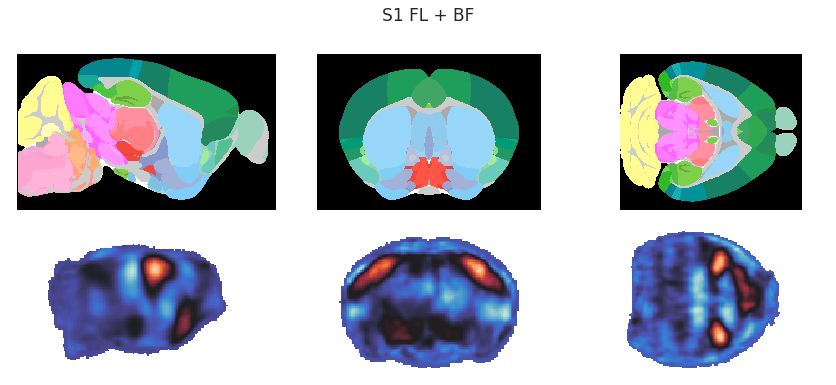

In [18]:
comp_plt(4, [5000, 3000, 4000], title)

#### Component 5

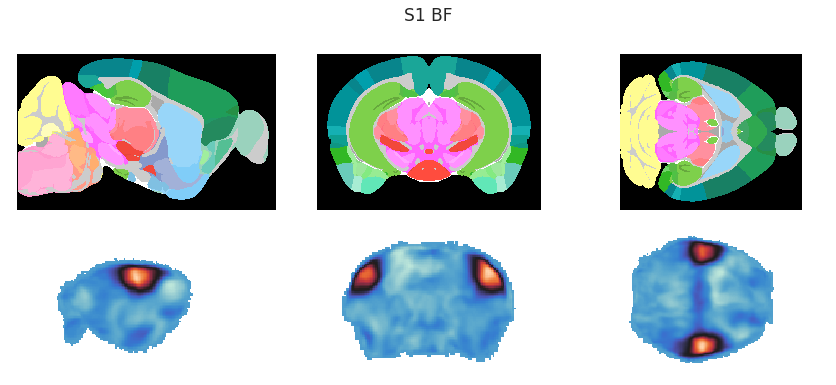

In [19]:
title = 'S1 BF'
comp_plt(5, [8000, 3000, 4000], title, [25, 95, 62])

#### Component 6

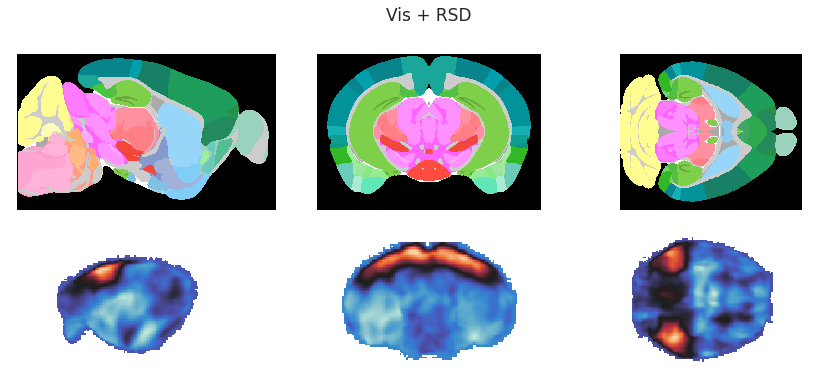

In [20]:
title = 'Vis + RSD'
comp_plt(6, [8000, 3000, 4000], title, [28, 65, 64])

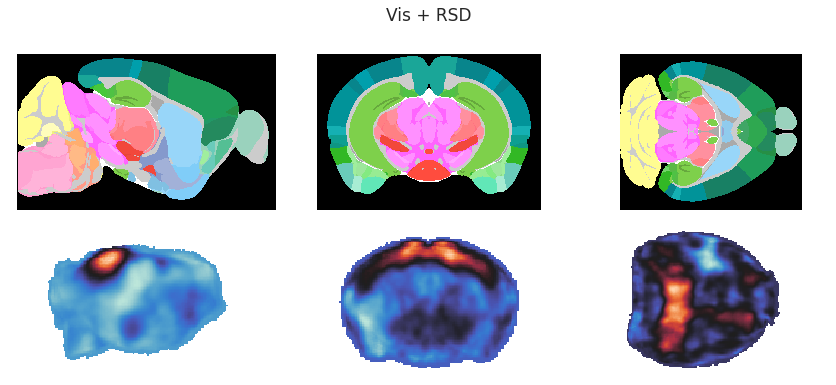

In [21]:
comp_plt(6, [8000, 3000, 4000], title)

#### Component 7

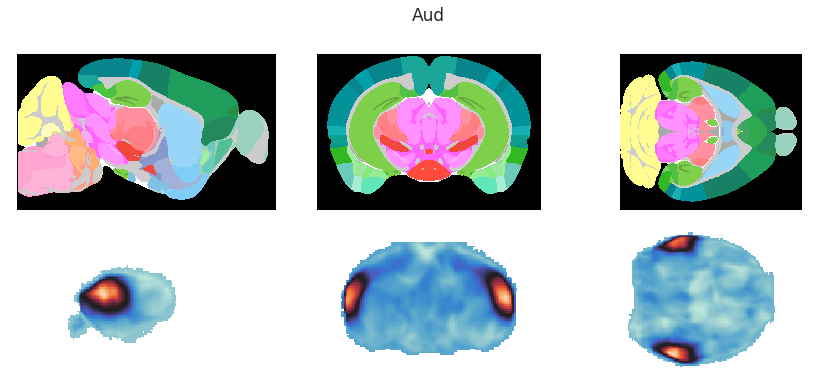

In [22]:
title = 'Aud'
comp_plt(7, [8000, 3000, 4000], title, [18, 70, 55])

#### Component 8

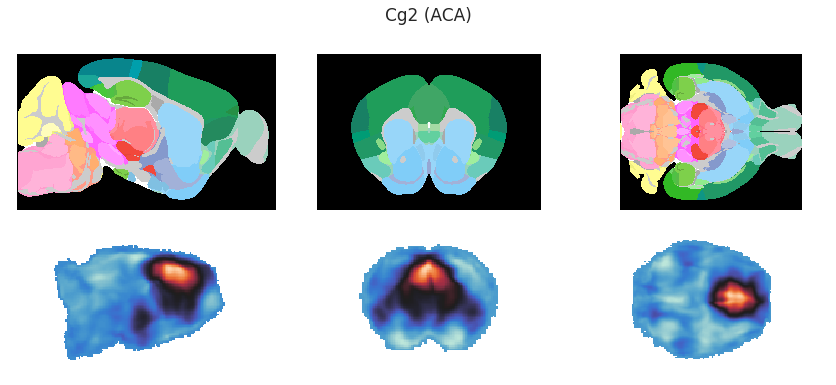

In [23]:
title = 'Cg2 (ACA)'
comp_plt(8, [4000, 5000, 4000], title, [60, 120, 66])

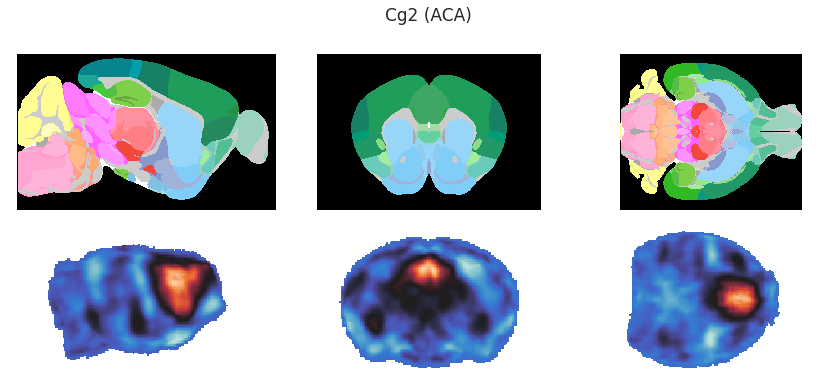

In [24]:
comp_plt(8, [4000, 5000, 4000], title)

#### Component 9

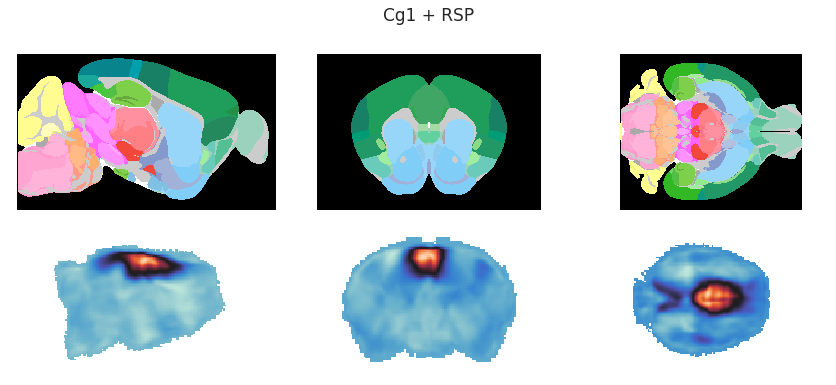

In [25]:
title = 'Cg1 + RSP'
comp_plt(9, [4000, 5000, 4000], title, [59, 90, 69])

#### Component 10

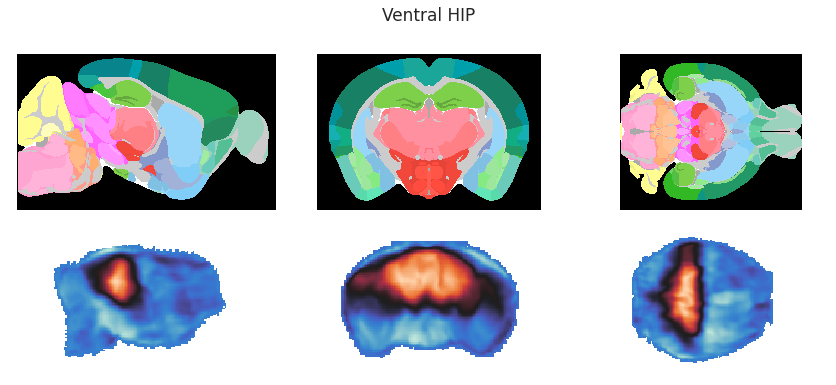

In [26]:
title = 'Ventral HIP'
comp_plt(10, [7000, 5000, 4000], title, [50, 78, 63])

#### Component 11

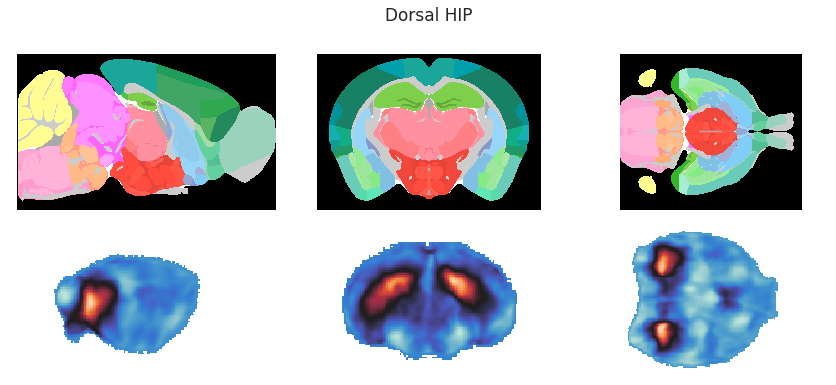

In [27]:
title = 'Dorsal HIP'
comp_plt(11, [7000, 6000, 6000], title, [30, 65, 46])

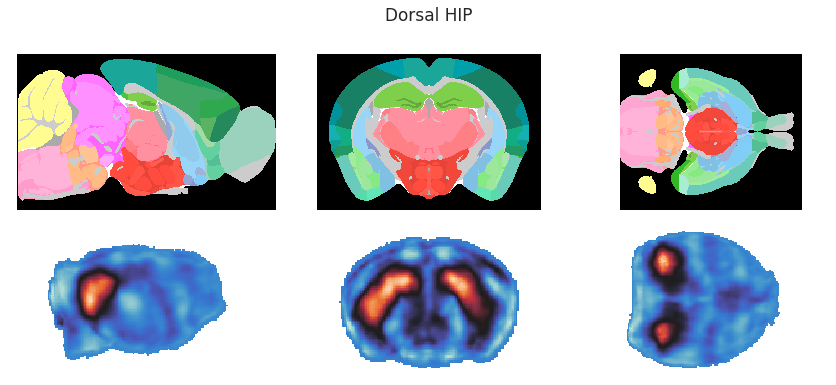

In [28]:
comp_plt(11, [7000, 6000, 6000], title)

#### Component 12

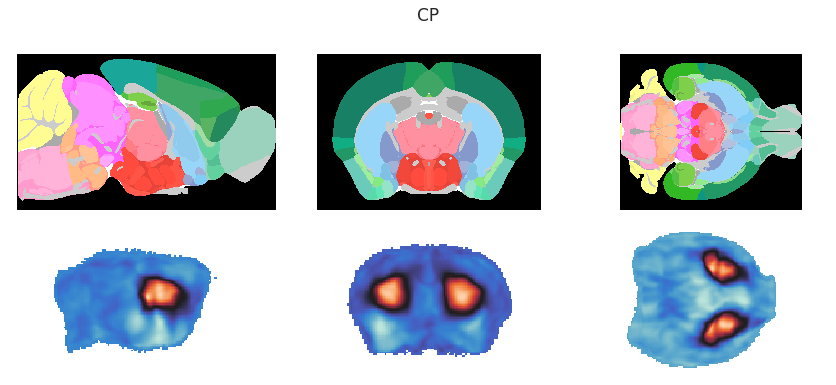

In [29]:
title = 'CP'
comp_plt(12, [6000, 5000, 6000], title, [39, 105, 48])

#### Component 13

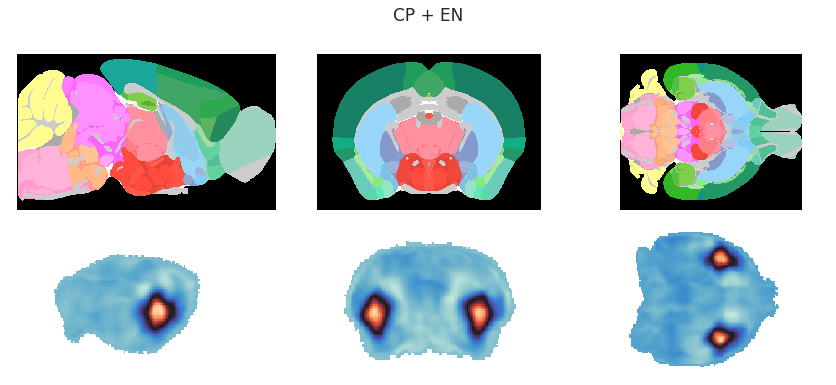

In [30]:
title = 'CP + EN'
comp_plt(13, [6000, 5000, 6000], title, [30, 100, 40])

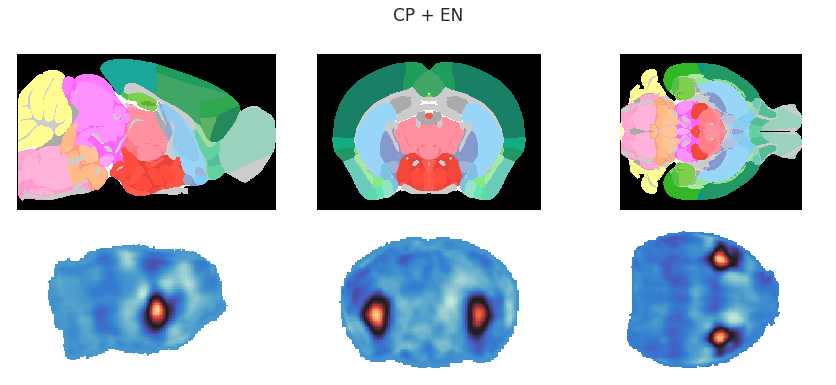

In [31]:
comp_plt(13, [6000, 5000, 6000], title)

#### Component 14

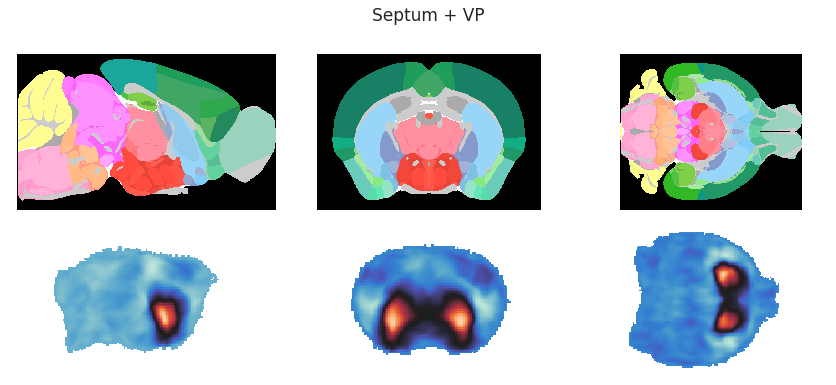

In [32]:
title = 'Septum + VP'
comp_plt(14, [6000, 5000, 6000], title, [40, 110, 42])

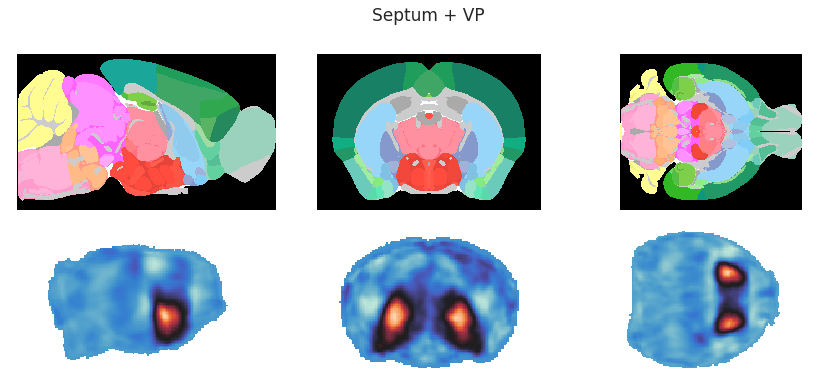

In [33]:
comp_plt(14, [6000, 5000, 6000], title)

#### Component 15

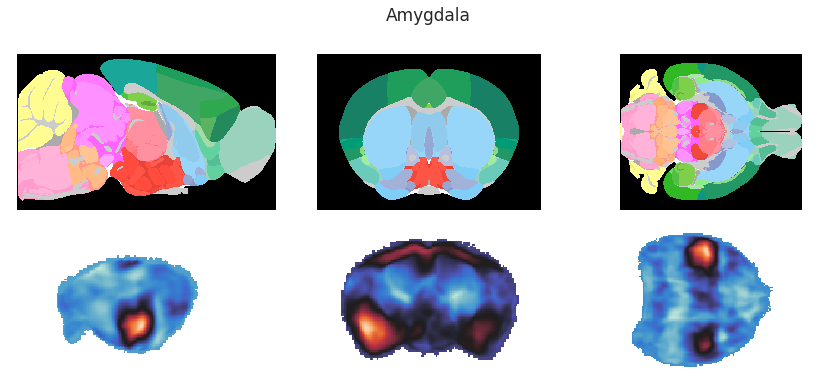

In [34]:
title = 'Amygdala'
comp_plt(15, [5000, 5000, 6000], title, [28, 82, 35])

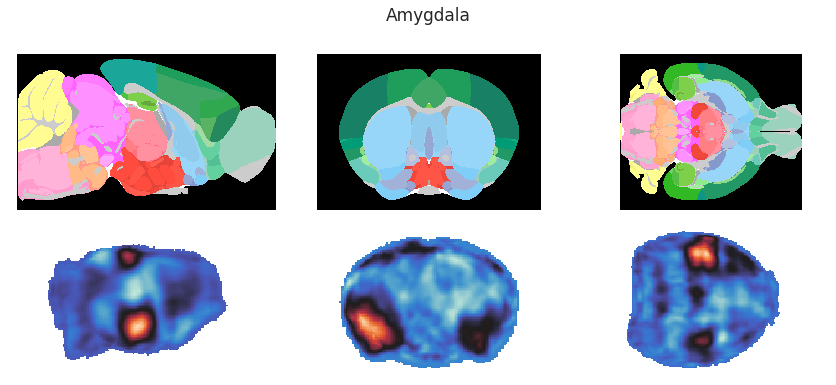

In [35]:
comp_plt(15, [5000, 5000, 6000], title)

#### Component 16

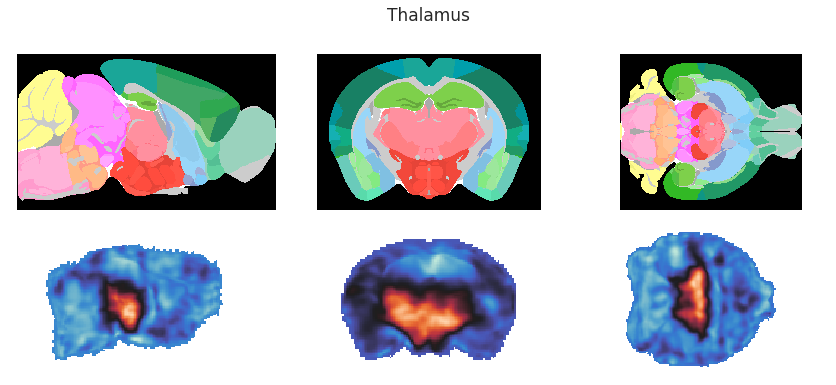

In [36]:
title = 'Thalamus'
comp_plt(16, [7000, 5000, 6000], title, [50, 85, 39])

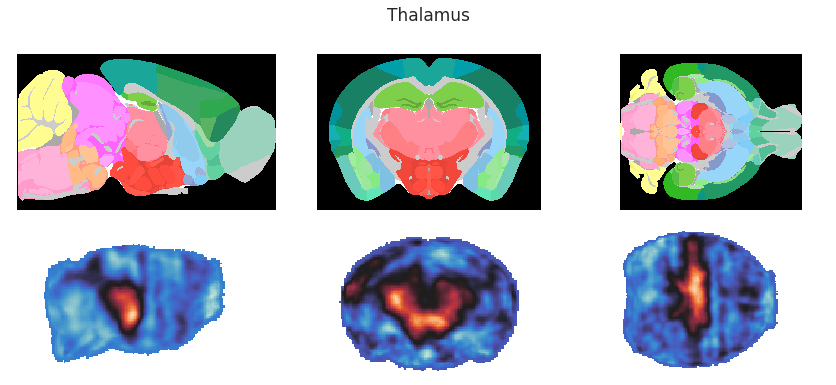

In [37]:
comp_plt(16, [7000, 5000, 6000], title)

#### Component 17

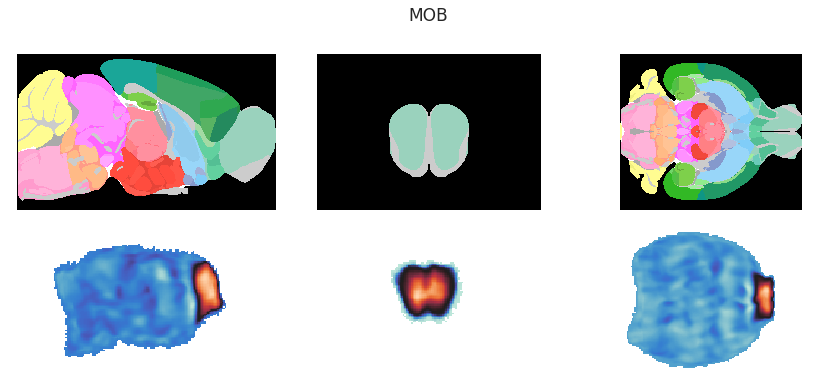

In [38]:
title = 'MOB'
comp_plt(17, [1000, 5000, 6000], title, [50, 140, 50])

## Gozzi

In [ ]:
from register.atlas import Allen
al = Allen(full_load=True)

In [106]:
_dir = '/home/hadi/Documents/MouseConnectome/03_modules_and_connector_hubs/00_modules'
file = pjoin(_dir, 'modules_consensus_unified.nii.gz')
modules = ants.image_read(file)
modules

ANTsImage (RPI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (114, 80, 132)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

<matplotlib.image.AxesImage object at 0x7f9ce2fc50d0>

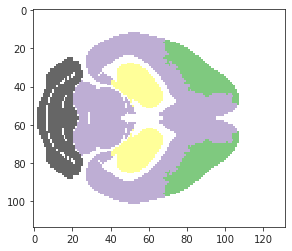

In [134]:
x2plt = modules[:, 60]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
plt.imshow(x2plt, cmap='Accent_r')

<matplotlib.image.AxesImage object at 0x7f9ce3910c10>

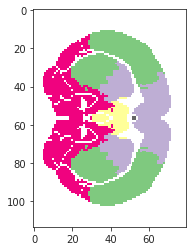

In [148]:
x2plt = modules[..., 80]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
plt.imshow(x2plt, cmap='Accent_r')

In [276]:
_dir = '/home/hadi/Documents/MouseDMN'

ica = np.zeros_like(al.template)
for i in range(5):
    f = f'ica_all_05_icasso_iter_1000_comp_{i}_mask_z_1_allen_masked_sym_thresh.nii.gz'
    img = ants.image_read(pjoin(_dir, f))
    img = np.transpose(img.numpy(), (2, 1, 0))
    img = img[::-1][:, ::-1]
    ica[img > 0] = i + 1

<matplotlib.image.AxesImage object at 0x7f9cdfa87700>

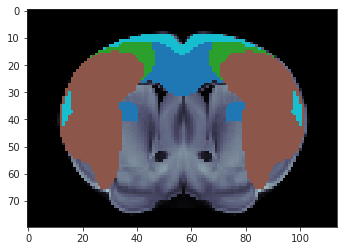

In [303]:
i =50

plt.imshow(al.template[i], cmap='bone')

x2plt = np.ma.masked_where(ica[i] == 0, ica[i])
plt.imshow(x2plt, cmap='tab10')

<matplotlib.image.AxesImage object at 0x7f9ce03fd0a0>

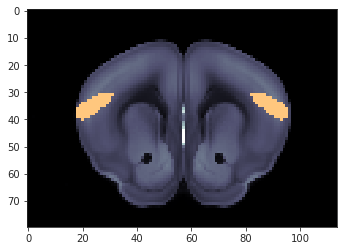

In [275]:
i = 40

plt.imshow(al.template[i], cmap='bone')

x2plt = np.ma.masked_where(img[i] == 0, img[i])
plt.imshow(x2plt, cmap='copper_r')

## Render

In [304]:
sys.path.insert(0, pjoin(git_dir, 'vedo'))
sys.path.insert(0, pjoin(git_dir, 'brainrender'))

from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume
from register.atlas import load_bg_atlas

cmap = sns.color_palette('turbo', as_cmap=True)

In [306]:
np.unique(ica[ica.nonzero()])

array([1, 2, 3, 4, 5], dtype=uint32)

In [ ]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False


scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

alpha = 1.0
base_name = 'none'  # 'Isocortex'

save_name = f'columnar_n{mice.cfg.nn}*{mice.cfg.ll}'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(base_name, alpha=0.7, color='k')

surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions), total=len(regions)):
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = [
    f"k{len(regions)}",
]
if save_name:
    html_file = [f"{save_name}"] + html_file
html_file = '_'.join(html_file) + ".html"
html_file = pjoin(save_dir, html_file)

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()